 
<table style="width:100%">
  <tr style="background-color:#002147">
    <th><p style="color:white">Professional Programme, Department of Computer Science, University of Oxford</th> 
  </tr>
</table>



#  Things of the Internet (TOI)





# LAB 1: RF Based Positioning
# SAMPLE SOLUTIONS

Please note the submission deadline for this report is Tuesday 12:00 PM, March 21st, 2023.

Your name:

##  Introduction

Localization is a key capability for things of the internet. Things need to know where they are to provide context to sensor readings. There are many ways of working out where a sensor is, ranging from GPS to inertial measurement units. However, one of the simplest techniques is to use measurements of ambient radio signal strength e.g. WiFi. Things are equipped with wireless transceivers anyway for communication, so the key is to try and exploit the transceiver to give measurements of location. This is particularly well suited to indoor settings, where a number of APs (access points/routers) are installed to provide good communication coverage so mobile devices can connect to a wireless network. The operating principle is simple: the closer the device is to an AP, the stronger the received signal strength is. However, the devil is in the details – the surrounding environment (walls, people, furniture, obstacles etc etc) all conspire to alter the relationship between signal strength and distance, so what starts off as a nice straight line in theory, turns into a very wiggly and noisy relationship. What is worse, this relationship is dynamic as well – a stationary WiFi device will typically experience a variation in signal strength over time.

So the question is: how are we going to use these noisy measurements to estimate a device’s location and how accurate can it be?
Rather than using a physics based model and trying to model and represent all the sources of disturbance, we take a much simpler approach. We approach the problem by breaking it down into two stages. In the first stage (the offline phase), we manually survey the signal strengths, i.e. we stand in a surveyed location and record what APs can be heard and with what strength. We obtain a vector (tuple) of measurements e.g. <X:-20,Y:-30,Z-32> could be the vector from one location, where we can hear APs X,Y and Z and <W:-40,Z-60> could be the vector from another location where we can hear APs W and Z. These vectors of signal strength are commonly called fingerprints i.e. the hope is that they are sufficiently unique and discriminative such that every location has a different fingerprint. Obviously, there is a time (and consequently financial) cost in building the map, so there is a question about how precisely the map needs to be surveyed e.g. on a 1 m grid spacing or on a 5 m grid spacing or even simply in the centre of each room.

In the second phase (the online phase), the device will record a vector of signal strengths. The goal now is to come up with some algorithm that, with the aid of the map collected in the offline phase, could accurately determine the location of the device. There are many different approaches to doing this, and the aim of this lab is to demonstrate how a location system could be built using WiFi signal strength measurements, to consider factors which would impact its performance, and to discuss its relative merits.


<div class="alert alert-warning">
<b>NOTE</b> The labs in this course are based on Python 3.7. Please refer to the environment setting introduction for details. If you have any problems with Python version please ask for help.
</div> 


## Exploratory Data Analysis

We have collected a set of data for use in this lab. During the offline phase we survey the environment collecting RSS measurements. For this demonstration we have collected 60 samples per location. Navigate to “data/set1/wifiData/” and open “Wifi_14.txt” with a text editor to look at a sample file. The first few lines look like the following:

`
2 4
1 AP_1 -37.89
2 AP_2 -52.63
3 AP_3 -44.98
4 AP_1 -38.68
5 AP_2 -61.14
6 AP_3 -35.08
7 AP_1 -39.46
8 AP_2 -61.62
9 AP_3 -47.00
10 AP_1 -38.00
11 AP_2 -60.69
.....`

The first line in the file is the survey coordinate i.e. (x = 2 m, y = 4 m).  The remainder of the lines detail the signal strengths in dBm from each access point. Note that each access point normally has a long BSSID as a unique identifier (e.g. `d8:c7:c8:cc:43:24`), but we have made things simpler here for ease of understanding.

Each file corresponds to a different survey location and typically 60 measurements are taken from each AP. In this dataset (set1), there are 3 APs in range, and in total we have collected Wi-Fi samples from 121 locations. 

During the online phase we want to estimate the user’s unknown location using RSS readings collected at that location. There we will use the test data set.

To simplify things, we have couple of functions pre-written for us to do the data loading and processing - this should make it simpler to focus on the interesting parts of this challenge.

Finally, we have collected two datasets (i.e. set1 and set2); set1 contains RSS measurements with respect to 3 APs and set2 with respect to 5 APs.

### Loading and visualizing

We have written some helper functions which load the datasets (both test and train) and visualize their spatial distribution, which can be found in `helper.py`. 

In [1]:
import helper as myhelper

def get_location(dataset, index):
    """ This function will give us the location """
    x = dataset[index, 1]
    y = dataset[index, 2]
    return x, y
    
def get_AP_signal_strength(dataset, index, AP_n, num_of_samples):
    """ 
    This function will give us a list of measurements from the AP number AP_n.
    Set the num_of_samples according to the number of measurements in the train or the test set.
    """
    signal_strenghts = dataset[index,3+AP_n*num_of_samples:3+(AP_n+1)*num_of_samples]
    return signal_strenghts


The function `load_wifi_data` has the following API

```python
def load_wifi_data(data_folder, n_samples, n_ap):
    """
    :param data_folder: Location of WiFi RSS data
    :param n_samples: Number of RSS samples to return for each location
    :param n_ap: Number of access points
    :return: train and test wifi databases
    """
 ```
 
Lets load up the train and test datasets from Set1 (3 APs).

In [2]:
import os
parent_dir = os.path.abspath(os.path.join('../..'))
datasetpath = os.path.join(parent_dir,'lab1','data','set1')
NUMBER_OF_APS = 3
MAX_SAMPLES = 60
trainData,testData = myhelper.load_wifi_data(datasetpath,MAX_SAMPLES,NUMBER_OF_APS)

The dataset is stored simply as a large array, with the following structure.
![db1.png](db1.png)


Lets look at the first row of the training dataset. It corresponds to the readings obtained from the location (20,  14)

In [3]:
# look a the first row of the array
trainData[0,:]

array([  0.  ,  20.  ,  14.  , -50.57, -49.84, -49.22, -49.82, -50.12,
       -51.3 , -50.59, -50.24, -50.45, -51.18, -49.14, -50.42, -50.49,
       -49.95, -49.73, -50.71, -50.54, -50.4 , -50.6 , -49.85, -50.  ,
       -50.91, -49.88, -50.87, -50.35, -51.05, -50.79, -50.48, -50.91,
       -50.51, -50.01, -50.4 , -51.31, -50.39, -49.3 , -50.76, -50.69,
       -50.34, -49.77, -50.34, -50.97, -50.43, -49.7 , -50.85, -50.21,
       -51.47, -50.7 , -49.95, -49.79, -50.67, -50.66, -50.59, -50.48,
       -49.97, -50.69, -49.61, -50.5 , -50.66, -50.26, -50.53, -59.05,
       -60.34, -67.09, -48.81, -58.11, -59.4 , -60.42, -61.92, -55.32,
       -56.3 , -53.92, -53.19, -61.42, -64.16, -63.49, -58.82, -61.25,
       -63.06, -54.49, -61.15, -61.12, -52.44, -58.12, -68.37, -56.71,
       -64.47, -61.95, -56.02, -71.58, -64.37, -58.08, -52.77, -48.  ,
       -57.01, -64.59, -65.92, -45.54, -53.64, -54.1 , -56.12, -47.9 ,
       -56.67, -63.15, -57.95, -55.44, -65.06, -72.21, -66.09, -60.85,
      

This is a bit hard to read through, so we have prepared couple of functions that will help you navigating this data:

In [4]:
# Getting the location:
# This will give us the [x,y] coordinates for the asked index
i = 0
x, y = get_location(trainData, index = i)
print("Measurement with the index",i,"was conducted at location",x,y)

Measurement with the index 0 was conducted at location 20.0 14.0


<div class="alert alert-info">
Q: If we get this information from the testData (the loaded test dataset), what do you see? Comment on that.
</div> 	

Your answer: 
> Ground Truth, for example the measurement with index 0 has location (3,3) :

In [5]:
get_location(testData, index = 0)

(3.0, 3.0)

Similarly, we prepared the function <strong>get_AP_signal_strength()</strong> to get the signal strenghts measured at this index.

Just to note "num_of_samples" refers to how many measurements we made. The training set has 60, while the testing set has 50.

In [6]:
AP_n = 0 # 0 corresponds to AP1, 1 to AP2, ...
get_AP_signal_strength(trainData, index=0, AP_n=AP_n, num_of_samples=60)

array([-50.57, -49.84, -49.22, -49.82, -50.12, -51.3 , -50.59, -50.24,
       -50.45, -51.18, -49.14, -50.42, -50.49, -49.95, -49.73, -50.71,
       -50.54, -50.4 , -50.6 , -49.85, -50.  , -50.91, -49.88, -50.87,
       -50.35, -51.05, -50.79, -50.48, -50.91, -50.51, -50.01, -50.4 ,
       -51.31, -50.39, -49.3 , -50.76, -50.69, -50.34, -49.77, -50.34,
       -50.97, -50.43, -49.7 , -50.85, -50.21, -51.47, -50.7 , -49.95,
       -49.79, -50.67, -50.66, -50.59, -50.48, -49.97, -50.69, -49.61,
       -50.5 , -50.66, -50.26, -50.53])

In [7]:
AP_n = 0
get_AP_signal_strength(testData, index=0, AP_n=AP_n, num_of_samples=50)

array([-38.05, -39.02, -38.6 , -37.72, -39.11, -38.91, -37.81, -38.1 ,
       -37.88, -38.93, -38.76, -37.86, -37.78, -37.94, -38.31, -37.95,
       -38.48, -37.76, -38.01, -38.03, -38.66, -38.2 , -37.86, -37.94,
       -39.16, -37.71, -38.5 , -38.02, -38.5 , -37.79, -38.49, -37.99,
       -37.66, -38.05, -37.6 , -37.99, -38.88, -38.57, -38.33, -38.27,
       -38.39, -38.31, -37.73, -36.93, -38.88, -38.22, -37.24, -37.8 ,
       -38.32, -37.9 ])

Investigate the sample strengths from AP1 (we the first AP by setting "AP_n=0") at this location point, using the snippet below. 

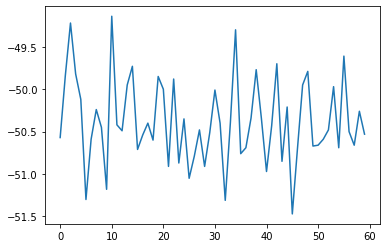

In [8]:
import pylab
import numpy as np
signalStrengthAP1 = get_AP_signal_strength(trainData, index=0, AP_n=0, num_of_samples=60)
pylab.plot(signalStrengthAP1)
pylab.show()

<div class="alert alert-info">
Q: What do you notice about the signal strength readings?
</div> 

Your answer: 
> Not stable, fluctuates in an interval. This is because of random variations e.g. multipath or noise in the radio channel itself.

<div class="alert alert-info">
Q: Change the location index and examine what happens to the signal strength. Is there any pattern you can see?
</div> 

Your answer: 
> The value fluctuates around a certain value

<div class="alert alert-info">
Q: Can you estimate the likely position of AP1?
</div> 

Your answer: 
> (6,6)

In [9]:
# We can explore this by searching for the strongest (average) signal around the whole room...

max_signal = -9999.
max_signal_location = None, None

for i in range(len(trainData)):
    x,y = get_location(trainData, index=i)
    signal_strengths = get_AP_signal_strength(trainData, index=i, AP_n=0, num_of_samples=60)
    mean_signal_strength = np.mean(signal_strengths)
    
    if mean_signal_strength > max_signal:
        max_signal_location = x,y
        max_signal = mean_signal_strength

print("Maximal average signal is at", max_signal_location, "with", max_signal)

Maximal average signal is at (6.0, 6.0) with -24.95


<div class="alert alert-info">
Q: Can you check the locations (using "get_location(trainData, index)") where we made these measurements - can you see anything strange about them?
</div> 	

Your answer: 
> The locations in the training dataset (trainData) are jumping by 2, they start at location (0,0) and end at (20, 20). In more detail see the prints below:

In [10]:
for i in range(len(trainData)):
    print("Measurement", i, "was made at x,y :", get_location(trainData, index=i))

Measurement 0 was made at x,y : (20.0, 14.0)
Measurement 1 was made at x,y : (18.0, 4.0)
Measurement 2 was made at x,y : (14.0, 6.0)
Measurement 3 was made at x,y : (6.0, 14.0)
Measurement 4 was made at x,y : (2.0, 16.0)
Measurement 5 was made at x,y : (16.0, 12.0)
Measurement 6 was made at x,y : (2.0, 20.0)
Measurement 7 was made at x,y : (6.0, 2.0)
Measurement 8 was made at x,y : (14.0, 20.0)
Measurement 9 was made at x,y : (0.0, 2.0)
Measurement 10 was made at x,y : (4.0, 16.0)
Measurement 11 was made at x,y : (10.0, 6.0)
Measurement 12 was made at x,y : (12.0, 6.0)
Measurement 13 was made at x,y : (12.0, 8.0)
Measurement 14 was made at x,y : (14.0, 18.0)
Measurement 15 was made at x,y : (20.0, 16.0)
Measurement 16 was made at x,y : (8.0, 2.0)
Measurement 17 was made at x,y : (4.0, 10.0)
Measurement 18 was made at x,y : (10.0, 12.0)
Measurement 19 was made at x,y : (18.0, 0.0)
Measurement 20 was made at x,y : (8.0, 20.0)
Measurement 21 was made at x,y : (14.0, 16.0)
Measurement 22 w

<div class="alert alert-success">
Advanced question: (optional) Can you visualize 2-D map of signal strength for each access point?<br>
<i>(Hint: use the prepared functions get_location() and get_AP_signal_strength())</i>
</div> 

Your answer: 

[[-44.4925     -43.02433333 -41.87616667 -41.27216667 -41.91066667
  -43.05866667 -44.54133333 -45.93983333 -47.38483333 -48.72266667
  -49.86766667]
 [-43.02716667 -40.88416667 -38.53133333 -37.71616667 -38.62083333
  -40.70483333 -43.1425     -45.06466667 -46.60166667 -48.16083333
  -49.39433333]
 [-41.7395     -38.66516667 -34.49316667 -31.246      -34.45233333
  -38.721      -41.84366667 -44.20933333 -46.269      -47.8075
  -49.20283333]
 [-41.3505     -37.5695     -31.235      -24.95       -31.37833333
  -37.62316667 -41.24266667 -43.92916667 -45.9815     -47.67633333
  -49.064     ]
 [-41.8495     -38.554      -34.455      -31.33216667 -34.58566667
  -38.81       -41.694      -44.262      -46.263      -47.847
  -49.17066667]
 [-43.07683333 -40.806      -38.703      -37.664      -38.83083333
  -40.79966667 -42.9715     -44.99       -46.6035     -48.18366667
  -49.4375    ]
 [-44.54783333 -42.95466667 -41.82433333 -41.40583333 -41.76066667
  -43.0075     -44.40966667 -46.01       -

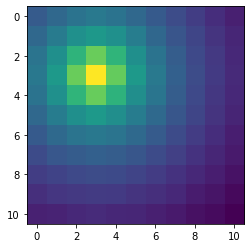

In [11]:
import numpy as np
heatmap = np.zeros((11,11)) # we create an empty array to fill in the average strenghts
for i in range(len(trainData)):
    x,y = get_location(trainData, index=i)
    signal_strengths = get_AP_signal_strength(trainData, index=i, AP_n=0, num_of_samples=60)
    mean_signal_strength = np.mean(signal_strengths)
    
    # we divide the location index - see the previous answer, looks like the measurements were made in increments of 2
    heatmap[ int(x/2), int(y/2) ] = mean_signal_strength
    
print(heatmap)
pylab.imshow(heatmap)


## A simple approach to finding location

Now that we have a better understanding of how the signals vary over space (and time), we can now try and solve the localization problem: given a set of signal strengths at an unknown location and an offline map, can we find the best estimate of the device position?

One of the simplest approaches is just a nearest neighbour lookup i.e. we just compare our candidate set of signal strengths to the signal strengths in the offline map and find the closest match. 

<div class="alert alert-info">
Q: What would be a good way of working out how "far" two sets of signal strengths are from each other?
</div> 

Your answer: 
> e.g.: Euclidean Distance of mean value of both sets. Or perhaps simply <code>abs(mean(RSSI_1) - mean(RSSI_2))<code>

Rather than using all the raw information in the table, it perhaps would be more helpful to turn the 60 readings from each AP into representative statistics. 

<div class="alert alert-info">
Q: What are some sensible statistics that could be used?
</div>

Your answer: 

>There are many options here. A simple, yet robust option is to use the mean or median as a measure of centrality and the interquartile range (difference between top 75% and bottom 25% measurements) as a measure of spread.


>An alternative is to model (e.g. with a Gaussian/Normal distribution or similar) the centre and spread of the measurements.

In this approach, we will simply compute the mean of the readings in the map for each AP. We will then compute the difference between the trial signal strength and each of the values in the map, recording the index of the smallest distance. Lets start from the first point in the testData set.

<div class="alert alert-info">
Q: What is the ground-truth location of this point?
</div>

Your answer: 
> The first line of the file testRow[1:3] - or the answer we get from the function get_location() when we give it the testData as dataset:

In [12]:
get_location(testData, index=0)

(3.0, 3.0)

Fill in the skeleton code below to find the closest point in the offline map to the candidate point. Note that although we take 50 samples in the test data set, we are just using the first sample point i.e. an instantaneous snap-shot.

In [13]:
import numpy as np

def predict(i):
    # Extract the ground-truth location
    groundTruthX, groundTruthY = get_location(testData, index=i)
    
    # Take the Signal Strengths of each AP in the trial point
    testAP1signals = get_AP_signal_strength(testData, index=i, AP_n=0, num_of_samples=50) # < remember, the test dataset has 50 measurements!
    testAP2signals = get_AP_signal_strength(testData, index=i, AP_n=1, num_of_samples=50)
    testAP3signals = get_AP_signal_strength(testData, index=i, AP_n=2, num_of_samples=50)
    
    # We can check just the fist measured value, or use something more representative, such as the mean of these values...
    
#     testAP1 = testAP1signals[0]
#     testAP2 = testAP2signals[0]
#     testAP3 = testAP3signals[0]
    testAP1 = np.mean(testAP1signals)
    testAP2 = np.mean(testAP2signals)
    testAP3 = np.mean(testAP3signals)
    
    lik = np.zeros(len(trainData))
    predicted_loc = np.zeros(2)
    # Iterate through the map
    for k in range(len(trainData)):
        surveyAP1mean = np.mean( get_AP_signal_strength(trainData, index=k, AP_n=0, num_of_samples=60) ) # < remember, the train dataset has 60 measurements!
        surveyAP2mean = np.mean( get_AP_signal_strength(trainData, index=k, AP_n=1, num_of_samples=60) )
        surveyAP3mean = np.mean( get_AP_signal_strength(trainData, index=k, AP_n=2, num_of_samples=60) )

        # compute the score here, and record the best position in the map
        dist = np.sqrt((testAP1-surveyAP1mean)**2+(testAP2-surveyAP2mean)**2+(testAP3-surveyAP3mean)**2)
        
        lik[k] = dist
    
    # Find the index of the most likely location
    ind = np.argmin(lik)
    
    predicted_loc = get_location(trainData, index=ind)
    return predicted_loc

# print(predict(0))
# print(get_location(testData, index=0))

<div class="alert alert-info">
Q: For the first testing data, modify the above code to find the closest match. What is the distance error between the ground-truth location and the closest match in the map?
</div>

Your answer: 
> The predicted location is \[4, 10\], the actual location is \[3, 3\].

<div class="alert alert-info">
Q: Now we try using the average value of the 50 samples in the data set instead of just the first one. Does the accuracy improve?
</div>

Your answer: 
> Yes.

> Other options are: using median value, using mean value, averaging top k, or weighted average of top k, etc.

<div class="alert alert-info">
Q: Wrap your code into a function `predict()` that you can use to run through all the test points to compute errors for each test location. Visualize the result with the help of the following plot function. What is the mean overall error? What is the worst case error? Which do you think is more important for a location system and why?
</div>

Your answer: 

-> Visualizing estimated trajectory...


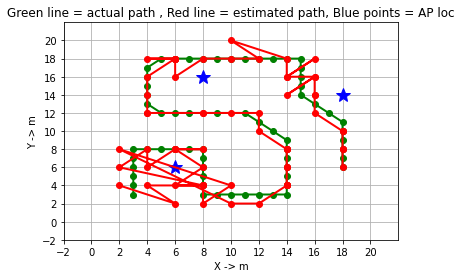

done



In [15]:
# Plot the actual and estimated locations
import matplotlib.pyplot as plt
def plot_path(actual_loc, predicted_loc, n_ap):
    """
    :param actual_loc: Actual locations
    :param predicted_loc: Estimated locations
    :param n_ap: Number of APs
    :return: null
    """
    print("-> Visualizing estimated trajectory...")

    if n_ap == 3:
        ap_loc = np.array([[6, 6], [8, 16], [18, 14]])
    else:
        ap_loc = np.array([[6, 6], [8, 16], [18, 14], [16, 4], [12, 10]])

    plt.figure()
    plt.plot(ap_loc[:, 0], ap_loc[:, 1], 'b*', markersize=15)
    plt.plot(actual_loc[:, 0], actual_loc[:, 1], 'go-', linewidth=2)
    plt.plot(predicted_loc[:, 0], predicted_loc[:, 1], 'ro-', linewidth=2)

    major_ticks = np.arange(-2, 22, 2)

    axes = plt.gca()
    axes.set_xlim([-2, 22])
    axes.set_ylim([-2, 22])
    axes.set_xticks(major_ticks)
    axes.set_yticks(major_ticks)
    plt.xlabel('X -> m')
    plt.ylabel('Y -> m')
    plt.title('Green line = actual path , Red line = estimated path, Blue points = AP loc')
    plt.grid(True)
    plt.show(block=False)

    print("done\n")
    return

#your code here
actual_loc1 = np.zeros((len(testData), 2))
predicted_loc1 = np.zeros((len(testData), 2))
for i in range(len(testData)):
    actual_loc1[i] = get_location(testData, i)
    predicted_loc1[i] = predict(i)

plot_path(actual_loc1,predicted_loc1,3)

#calculate mean error, median error, etc. here.

In [17]:
maximum_err = 0
total_err = 0
for i in range(0,len(actual_loc1)):
    err = np.sqrt((actual_loc1[i,0]-predicted_loc1[i,0])**2+(actual_loc1[i,1]-predicted_loc1[i,1])**2)
    if err > maximum_err:
        maximum_err = err
    total_err += err
avg_err = total_err/len(actual_loc1)
print("maximum error: ",maximum_err)
print("mean error: ",avg_err)

maximum error:  9.433981132056603
mean error:  1.4210947498468083


<div class="alert alert-info">
Q: (optional) Instead of finding the best (closest) match in the map, what if you instead found the top-k matches and then computed their mean? Do this centroid-weighting approach help or not?
</div>

Your answer: 
> depends on your algorithm, but typically it leads to more robust estimates

## HORUS: A probabilistic approach to location finding



Instead of just taking the mean value of the signal strengths in the map, we can consider including higher-order statistics as well, e.g. the variance (or standard-deviation) that reflect the variability in the signal over time. One of the first approaches to wifi fingerprinting proposed just this technique, which we will implement a simplified version of.

> Youssef, Moustafa, and Ashok Agrawala. "The Horus WLAN location determination system." Proceedings of the 3rd international conference on Mobile systems, applications, and services. ACM, 2005.


### Mathematical Model

Let $X$ be a 2-dimensional physical space. At each location $x \in X$, we can measure the signal strength from $k$ access points. We denote the $k$-dimensional signal strength space as $S$. We denote samples from the signal strength space $S$ as $s$. We also assume that the samples from different access points are independent. 
The problem becomes, given a signal strength vector $s=(s_1, s_2 ... s_k)$ , we want to find the location $x \in X$ that maximizes the probability $\mathrm{P} (x \vert s)$

1)	*Offline phase:* During the offline phase, the Horus system estimates the signal strength histogram for each access point at each location. These histograms represent the Horus system’s radio map. 


2)	*Online phase:* Given a signal strength vector $s=(s_1, s_2 ... s_k)$ , we want to find the location $x \in X$ that maximizes the probability  $P(x  \vert   s)$, i.e. we want to find

$$\newcommand{\argmaxI}{\mathop{\mathrm{argmax}}\nolimits} \argmaxI_x \mathrm{P} (x \vert s)$$
 

Using Bayes’ theorem, this can be shown to be equivalent to:

$$\newcommand{\argmaxI}{\mathop{\mathrm{argmax}}\nolimits} 
\argmaxI_x \mathrm{P} (x \vert s) =
\argmaxI_x \mathrm{P} (s \vert x) =
\argmaxI_x \prod_{i=1}^{k} \mathrm{P} (s_i \vert x) $$
 
Effectively, it says that we should find the location in the map that would maximize the likelihood (probability) of resulting in the sampled measurements.

### Offline Phase: Build a histogram map

In the offline phase, instead of storing N different raw measurements, or aggregating them using their mean, we will instead look at their distribution. Lets first investigate how best to represent the distribution compactly.


<div class="alert alert-info">
Q: Plot a histogram (hint: use `pylab.hist()`) of signal strengths from one AP for one location. What do you notice about the distribution? Does this hold for other points in the survey dataset?
</div>


(array([ 3.,  2.,  6., 13., 15.,  4.,  8.,  6.,  0.,  3.]),
 array([-51.47 , -51.237, -51.004, -50.771, -50.538, -50.305, -50.072,
        -49.839, -49.606, -49.373, -49.14 ]),
 <BarContainer object of 10 artists>)

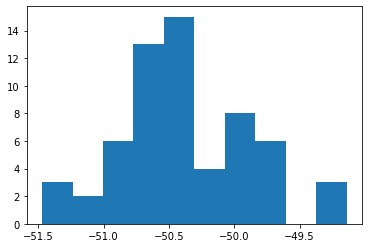

In [18]:
#your code here
pylab.hist(get_AP_signal_strength(trainData, index=0, AP_n=0, num_of_samples=60))

Your answer: 
> It looks like a normal (Gaussian) distribution.

Rather than storing the histogram as a set of bins, we can represent it as a normal (Gaussian) distribution. The normal distribution is parameterized by a mean $\mu$ and standard deviation $\sigma$. We can fit a normal distribution to a histogram of signal strengths to compactly represent the random variations, regardless of the number of samples in the histogram. We can use the helper function with the API below to transform the raw signal strength databases into normally distributed data.

```python
def fit_data(train_db, n_samples, n_ap):
    """
    :param train_db: RSS points collected at known locations
    :param n_samples: Number of RSS samples per location
    :param n_ap: Number of access points
    :return: Wifi fingerprint database; We approximate the RSS at each location with a Gaussian
    """
```    

Given a raw dataset of signal strengths as above, this transforms it into an array with the following structure:

![db2.png](db2.png)

This is accomplished in the two lines of code below. We also visualize a few samples to have a better understanding of the norm fitting process.

-> Modeling RSS with Gaussian dist...done
-> Modeling RSS with Gaussian dist...done


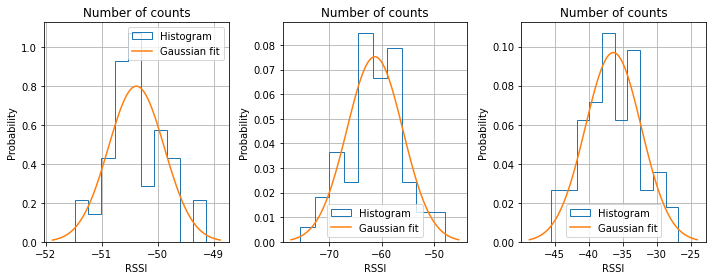

In [19]:
normTrainData = myhelper.fit_data(trainData,MAX_SAMPLES,NUMBER_OF_APS)
normTestData = myhelper.fit_data(testData,MAX_SAMPLES,NUMBER_OF_APS)

# visualization for a better understanding
# visualize location 0 AP1, location 1 AP 2 and location 2 AP 3
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
# Plot
fig, axs = plt.subplots(1,3, figsize=(10,4))

for measurement_idx in range(3):
        #Plot histogram
        n, bins, patches = axs[measurement_idx].hist(trainData[measurement_idx, 3+MAX_SAMPLES * measurement_idx: 3+MAX_SAMPLES*(measurement_idx + 1)], 
                                                     bins=10, density=True, histtype='step', cumulative=False, label='Histogram')

        #Compute and plot normal distribution
        mu = normTrainData[measurement_idx, 3+measurement_idx*2]
        sigma = normTrainData[measurement_idx, 4+measurement_idx*2]        
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        axs[measurement_idx].plot(x, norm.pdf(x, mu, sigma),label='Gaussian fit')
        
        #Set labels
        axs[measurement_idx].grid(True)
        axs[measurement_idx].legend()
        axs[measurement_idx].set_title('Number of counts')
        axs[measurement_idx].set_xlabel('RSSI')
        axs[measurement_idx].set_ylabel('Probability')
plt.tight_layout()
plt.show()

<div class="alert alert-info">
Q: What are the pros and cons of using the Gaussian distribution to represent the signal strength histogram. Can you provide some specific scenarios where it would be a bad approximation?
</div>

Your answer: 

> Gaussian is easy to understand and use and can be entirely described with two parameters. It models the distribution pretty well. However, if the environment is not stable, e.g., perhaps whether a door is open or clsoed might affect the signal strength at a certain location. For this location, if we only apply Gaussian distribution to this location, it would be inaccurate. An alternative would be to use a richer model e.g. a Gaussian Mixture Model or a bimodal distribution

### Online phase: find the best match

Make a new version of your `predict()` function above to use this probabilistic technique. In particular, you will need to compute the likelihood that a sample (e.g. the mean of signal strength from AP_1) is actually drawn from the offline-computed distribution. You can compute the likelihood as follows:

```python
from scipy.stats import norm

likelihood_AP1 = norm.pdf(trial_signal_strength_AP1, offline_mu_AP1, offline_sigma_AP1)
likelihood_AP2 = norm.pdf(trial_signal_strength_AP2, offline_mu_AP2, offline_sigma_AP2)
likelihood_AP3 = norm.pdf(trial_signal_strength_AP3, offline_mu_AP3, offline_sigma_AP3)
likelihood = likelihood_AP1 * likelihood_AP2 * likelihood_AP3
```

As the Bayes equation shows above, you can simply multiply these probabilities together. An alternative approach, which is numerically more stable, is to instead take the log-likelihood. By taking logs of both sides of the equation, the multiplication turns into an addition, and you can simply add the log-likelihood probabilities from each AP to obtain the overall log-likelihood.  

```python
from scipy.stats import norm

log_likelihood_AP1 = norm.logpdf(trial_signal_strength_AP1, offline_mu_AP1, offline_sigma_AP1)
log_likelihood_AP2 = norm.logpdf(trial_signal_strength_AP2, offline_mu_AP2, offline_sigma_AP2)
log_likelihood_AP3 = norm.logpdf(trial_signal_strength_AP3, offline_mu_AP3, offline_sigma_AP3)
log_likelihood = log_likelihood_AP1 + log_likelihood_AP2 + log_likelihood_AP3
```

<div class="alert alert-info">
Q: Implement the probabilistic approach to `predict()` and compare its performance to the methods based simply on the mean or the centroid.
</div>

Your answer: 
> See code below.

<div class="alert alert-success">
Advanced question (optional): Can you plot the error cumulative density function for each of your predict methods?
</div> 

Your answer: 
> See the cells below.

<div class="alert alert-info">
Q: (optional) How well do your methods work for the other dataset, with 5 APs?
</div>

This part is left for you to try.

-> Visualizing estimated trajectory...


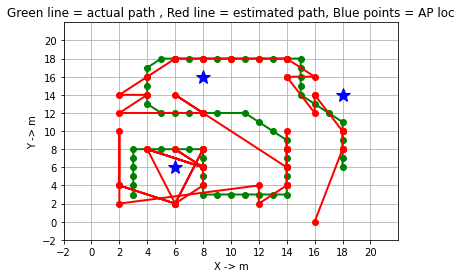

done



In [20]:
#your code here

#Note: this is a different implementation of predict, which returns all the ground truth and predictions as to N*2 arrays.
from scipy.stats import norm
def predict():
    
    #print "running Horus"

    predicted_loc = np.zeros((len(testData), 2))
    actual_loc = np.zeros((len(testData), 2))

    for i in range(0, len(testData)):
        # the GT location:
        actual_loc[i] = get_location(testData, index=i)

        # Keep track of the likelihood being in each location
        loglik = np.zeros(len(normTrainData))

        # Go through each location in the wifi_db
        for j in range(0, len(normTrainData)):

            # Take account all access points
            for k in range(0, NUMBER_OF_APS):
                # Get the RSS data at the unknown location
                rssdat = get_AP_signal_strength(testData, index=i, AP_n=k, num_of_samples=50)

                # Calculate the mean
                test_point = np.mean(rssdat)

                # Calculate the loglikelihood
                mu = normTrainData[j, (k * 2) + 3]
                sigma = normTrainData[j, (k * 2) + 4]
                loglik[j] += norm.logpdf(test_point, mu, sigma)

        # Find the most likely location
        ind = np.argmax(loglik)
        predicted_loc[i] = get_location(normTrainData, index=ind)

    #print "done."
    return actual_loc, predicted_loc

(actual_loc,predicted_loc)=predict()
plot_path(actual_loc, predicted_loc, 3)

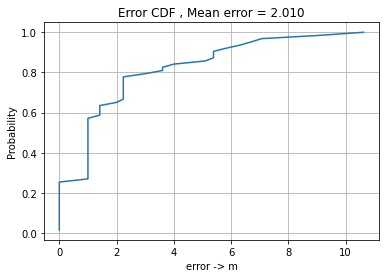

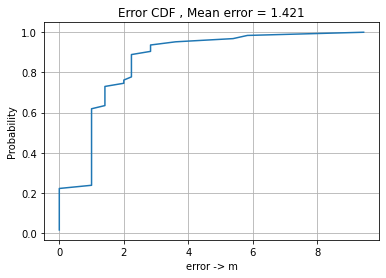

In [21]:
from statsmodels.distributions.empirical_distribution import ECDF
# Calculate and plot the localization error
def plot_error(actual_loc, predicted_loc):
    """
    :param actual_loc: Actual locations
    :param predicted_loc: Estimated Locations
    :return: null
    """

    #print "-> Calculating localization error..."

    err = np.zeros((1, len(actual_loc)))
    for i in range(0, len(actual_loc)):
        err[0, i] = np.sqrt((actual_loc[i, 0] - predicted_loc[i, 0]) ** 2 +
                            (actual_loc[i, 1] - predicted_loc[i, 1]) ** 2)

    mean_err = np.mean(err)

    ecdf = ECDF(err[0, :])
    plt.figure()
    plt.plot(ecdf.x, ecdf.y)
    plt.grid(True)
    plt.xlabel('error -> m')
    plt.ylabel('Probability')
    plt.title('Error CDF , Mean error = %.3f' % mean_err)
    plt.show(block=False)

    #print "done\n"
    return

plot_error(actual_loc,predicted_loc)

#previous method
plot_error(actual_loc1,predicted_loc1)



<div class="alert alert-info">
Q: (optional) Compare and contrast the techniques you have developed today. Consider aspects such as computational cost and factors such as how best to acquire and store the map. How can you update the map? Can you build a map without any surveying at all? Where should the computation happen? What is the impact of device specific variation e.g. different wireless network cards?
</div>

Your answer: 

> Using the mean is simple and straightforward, but not as accurate as modelling using a Gaussian. If we were doing WiFi based localization on a resource constrained device, fitting a Gaussian to a dataset can be quite expensive. Using the mean/median/interquartile range etc can serve as a simple approximation.

> Storing the map in terms of its distribution (e.g. mean and standard deviation) is cheap, as regardless of the number of measurements, only two parameters are required per location. However, if reality does not align well with the assumptions, e.g. the distribution is long-tailed, bimodal, or even multi-modal, then the Gaussian fit will be a poor approximation.

> To build a map without any surveying is hard, but not impossible. It is called WiFi SLAM (simultaneous localization and mapping). It can be augmented with other information such as from inertial measurement units, or using building floor plans. It is based on the assumption that people do not jump from one location to another location, but can only move to an adjacent location.

> Ideally, the computation should happen on the edge/IoT device, but sometimes it is more accurate to use the cloud, as it can have a richer model. Using a cloud model also allows the model to more easily use updated data from multiple users to build continually evolving maps.

> Due to different sensing abilities, different wireless network cards may perform differently. Thus, there needs to be a per-device calibration phase as well.